In [ ]:
import numpy as np
from time import time
import matplotlib.pyplot as plt
import networkx as nx

from qiskit import  QuantumCircuit, QuantumRegister, transpile,IBMQ
from qiskit.circuit import ParameterVector
from qiskit.opflow import X, Z, I,Y


from qiskit_ibm_runtime import QiskitRuntimeService, Session,Estimator,Sampler
from qiskit.algorithms import MinimumEigensolver, VQEResult
from qiskit.providers.aer import QasmSimulator, Aer
from qiskit_ibm_runtime import (QiskitRuntimeService, Session,
                                Estimator as RuntimeEstimator,
                                Sampler as RuntimeSampler,
                                Options)
from qiskit.primitives import Sampler,Estimator
from qiskit_aer.noise import NoiseModel


from lib import util_prova
import statistics

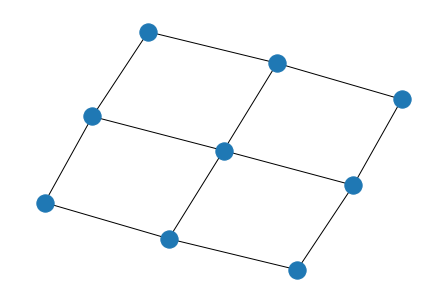

In [ ]:

g = nx.Graph()
 
g.add_edge(0, 1)
g.add_edge(1, 4)
g.add_edge(3, 4)
g.add_edge(0, 3)

g.add_edge(1, 2)
g.add_edge(2, 5)
g.add_edge(4, 5)


g.add_edge(5, 8)
g.add_edge(7, 8)
g.add_edge(4, 7)

g.add_edge(6, 3)
g.add_edge(6, 7)


 
nx.draw(g)
plt.show()

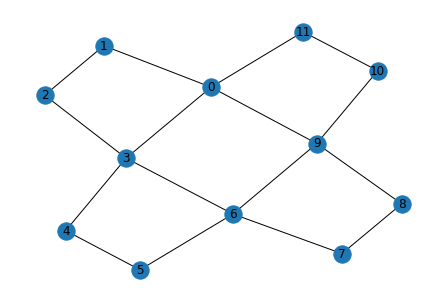

In [ ]:
g_edge_OBC = nx.Graph()
 
g_edge_OBC.add_edge(0, 1)
g_edge_OBC.add_edge(1, 2)
g_edge_OBC.add_edge(0, 3)
g_edge_OBC.add_edge(2, 3)

g_edge_OBC.add_edge(3, 4)
g_edge_OBC.add_edge(5, 6)
g_edge_OBC.add_edge(4, 5)
g_edge_OBC.add_edge(6, 3)

g_edge_OBC.add_edge(7,6)
g_edge_OBC.add_edge(7, 8)
g_edge_OBC.add_edge(9, 8)
g_edge_OBC.add_edge(9, 6)

g_edge_OBC.add_edge(9, 10)
g_edge_OBC.add_edge(10, 11)
g_edge_OBC.add_edge(11, 0)
g_edge_OBC.add_edge(0, 9)

 
nx.draw(g_edge_OBC,with_labels=True)
plt.show()

In [ ]:
def Hamiltonian_OBC(g,h):
  
  B1 = Z^Z^Z^Z^I^I^I^I^I^I^I^I  #0-1-2-3
  B2 = I^I^I^Z^Z^Z^Z^I^I^I^I^I  #3-4-5-6
  B3 = I^I^I^I^I^I^Z^Z^Z^Z^I^I  #6-7-8-9
  B4 = Z^I^I^I^I^I^I^I^I^Z^Z^Z  #9-10-11-0


  E0 = X^I^I^I^I^I^I^I^I^I^I^I
  E1 = I^X^I^I^I^I^I^I^I^I^I^I
  E2 = I^I^X^I^I^I^I^I^I^I^I^I
  E3 = I^I^I^X^I^I^I^I^I^I^I^I
  E4 = I^I^I^I^X^I^I^I^I^I^I^I
  E5 = I^I^I^I^I^X^I^I^I^I^I^I
  E6 = I^I^I^I^I^I^X^I^I^I^I^I
  E7 = I^I^I^I^I^I^I^X^I^I^I^I
  E8 = I^I^I^I^I^I^I^I^X^I^I^I
  E9 = I^I^I^I^I^I^I^I^I^X^I^I
  E10 = I^I^I^I^I^I^I^I^I^I^X^I
  E11 = I^I^I^I^I^I^I^I^I^I^I^X

  H=(h*B1) + \
    (h*B2) + \
    (h*B3) + \
    (h*B4) + \
    (g*E1) + \
    (g*E2) + \
    (g*E3) + \
    (g*E4) + \
    (g*E5) + \
    (g*E6) + \
    (g*E7) + \
    (g*E8) + \
    (g*E9) + \
    (g*E10) + \
    (g*E11) + \
    (g*E0) 
  return H

In [ ]:
H=Hamiltonian_OBC(1,1)

In [ ]:
plaquette_list=[[0,1,2,3],[6,7,8,9],[3,4,5,6],[9,10,11,0]]
vert_list=[1,2,3,4,5,6,7,8,9,10,11]
initial_layout=[1,4,7,10,12,13,14,11,8,5,3,2]

In [ ]:
from qiskit.algorithms import NumPyEigensolver

# find the first three (k=3) eigenvalues
exact_solver = NumPyEigensolver(k=20)
exact_result = exact_solver.compute_eigenvalues(H)
print(exact_result.eigenvalues)


# Save ground state energy for later
gs_energy = np.round(exact_result.eigenvalues[0], 4)

[-12.49728552 -10.72114762 -10.72114762 -10.72114762 -10.72114762
 -10.61768533 -10.61768533 -10.61768533 -10.61768533 -10.61768533
 -10.61768533 -10.61768533 -10.61768533  -9.48574639  -9.48574639
  -9.48574639  -9.48574639  -9.4788754   -9.4788754   -9.4788754 ]


In [ ]:
def ansatz_OBC(magnetic_list,electric_list,depth):
  theta = ParameterVector("t",depth*(len(magnetic_list)+len(electric_list)))
  qr=QuantumRegister(12)
  circuit = QuantumCircuit(qr)
  index = 0

  circuit.x(qr[i] for i in range (0,12))
  circuit.h(qr[i] for i in range (0,12))
  for _ in range (0,depth): 
    for edge in magnetic_list:

      circuit.cx(qr[edge[3]],qr[edge[2]])
      circuit.cx(qr[edge[2]],qr[edge[1]])
      circuit.cx(qr[edge[1]],qr[edge[0]])

      circuit.rz(theta[index],qr[edge[0]])

      circuit.cx(qr[edge[1]],qr[edge[0]])
      circuit.cx(qr[edge[2]],qr[edge[1]])
      circuit.cx(qr[edge[3]],qr[edge[2]])
    index+=1
    '''
      for vert in edge:
        circuit.rx(theta[index], qr[vert])
        index+=1
    '''
    circuit.barrier()
    for qubit in electric_list:
      circuit.rx(theta[index], qr[qubit])
    index+=1
    
    
    
  return circuit



In [ ]:
ansatz=ansatz_OBC(plaquette_list,vert_list,2)
ansatz.draw()

┌───┐┌───┐          ┌───┐┌──────────┐┌───┐                    »
 q2688_0: ┤ X ├┤ H ├──────────┤ X ├┤ Rz(t[0]) ├┤ X ├───────■────────────»
          ├───┤├───┤     ┌───┐└─┬─┘└──────────┘└─┬─┘┌───┐  │            »
 q2688_1: ┤ X ├┤ H ├─────┤ X ├──■────────────────■──┤ X ├──┼────────────»
          ├───┤├───┤┌───┐└─┬─┘                      └─┬─┘  │  ┌───┐     »
 q2688_2: ┤ X ├┤ H ├┤ X ├──■──────────────────────────■────┼──┤ X ├─────»
          ├───┤├───┤└─┬─┘                                  │  └─┬─┘┌───┐»
 q2688_3: ┤ X ├┤ H ├──■────────────────────────────────────┼────■──┤ X ├»
          ├───┤├───┤                                       │  ┌───┐└─┬─┘»
 q2688_4: ┤ X ├┤ H ├───────────────────────────────────────┼──┤ X ├──■──»
          ├───┤├───┤                                ┌───┐  │  └─┬─┘     »
 q2688_5: ┤ X ├┤ H ├────────────────────────────────┤ X ├──┼────■───────»
          ├───┤├───┤          ┌───┐┌──────────┐┌───┐└─┬─┘  │            »
 q2688_6: ┤ X ├┤ H ├──────────┤ X ├┤ Rz(t[0]) ├┤ X ├──■────┼────────────»
          ├───┤├───┤     ┌───┐└─┬─┘└──────────┘└─┬─┘┌───┐  │            »
 q2688_7: ┤ X ├┤ H ├─────┤ X ├──■────────────────■──┤ X ├──┼────────────»
          ├───┤├───┤┌───┐└─┬─┘                      └─┬─┘  │  ┌───┐     »
 q2688_8: ┤ X ├┤ H ├┤ X ├──■──────────────────────────■────┼──┤ X ├─────»
          ├───┤├───┤└─┬─┘                                  │  └─┬─┘┌───┐»
 q2688_9: ┤ X ├┤ H ├──■────────────────────────────────────┼────■──┤ X ├»
          ├───┤├───┤                                       │  ┌───┐└─┬─┘»
q2688_10: ┤ X ├┤ H ├───────────────────────────────────────┼──┤ X ├──■──»
          ├───┤├───┤                                     ┌─┴─┐└─┬─┘     »
q2688_11: ┤ X ├┤ H ├─────────────────────────────────────┤ X ├──■───────»
          └───┘└───┘                                     └───┘          »
«                                           ░                       ┌───┐»
« q2688_0: ─────────────────────────────■───░───────────────────────┤ X ├»
«                                       │   ░ ┌──────────┐     ┌───┐└─┬─┘»
« q2688_1: ─────────────────────────────┼───░─┤ Rx(t[1]) ├─────┤ X ├──■──»
«                                       │   ░ ├──────────┤┌───┐└─┬─┘     »
« q2688_2: ─────────────────────────────┼───░─┤ Rx(t[1]) ├┤ X ├──■───────»
«          ┌──────────┐┌───┐            │   ░ ├──────────┤└─┬─┘          »
« q2688_3: ┤ Rz(t[0]) ├┤ X ├────────────┼───░─┤ Rx(t[1]) ├──■────────────»
«          └──────────┘└─┬─┘┌───┐       │   ░ ├──────────┤               »
« q2688_4: ──────────────■──┤ X ├───────┼───░─┤ Rx(t[1]) ├───────────────»
«                           └─┬─┘┌───┐  │   ░ ├──────────┤               »
« q2688_5: ───────────────────■──┤ X ├──┼───░─┤ Rx(t[1]) ├───────────────»
«                                └─┬─┘  │   ░ ├──────────┤          ┌───┐»
« q2688_6: ────────────────────────■────┼───░─┤ Rx(t[1]) ├──────────┤ X ├»
«                                       │   ░ ├──────────┤     ┌───┐└─┬─┘»
« q2688_7: ─────────────────────────────┼───░─┤ Rx(t[1]) ├─────┤ X ├──■──»
«                                       │   ░ ├──────────┤┌───┐└─┬─┘     »
« q2688_8: ─────────────────────────────┼───░─┤ Rx(t[1]) ├┤ X ├──■───────»
«          ┌──────────┐┌───┐            │   ░ ├──────────┤└─┬─┘          »
« q2688_9: ┤ Rz(t[0]) ├┤ X ├────────────┼───░─┤ Rx(t[1]) ├──■────────────»
«          └──────────┘└─┬─┘┌───┐       │   ░ ├──────────┤               »
«q2688_10: ──────────────■──┤ X ├───────┼───░─┤ Rx(t[1]) ├───────────────»
«                           └─┬─┘     ┌─┴─┐ ░ ├──────────┤               »
«q2688_11: ───────────────────■───────┤ X ├─░─┤ Rx(t[1]) ├───────────────»
«                                     └───┘ ░ └──────────┘               »
«          ┌──────────┐┌───┐                                               »
« q2688_0: ┤ Rz(t[2]) ├┤ X ├───────■───────────────────────────────────────»
«          └──────────┘└─┬─┘┌───┐  │                                       »
« q2688_1: ──────────────■──┤ X ├──┼──────────────────

In [ ]:
from qiskit.algorithms.optimizers import SPSA,COBYLA,L_BFGS_B,SLSQP

spsa = SPSA(maxiter=100,blocking=False, allowed_increase=1, trust_region=False,
                 learning_rate=None, perturbation=None, last_avg=10, resamplings=1,
                 perturbation_dims=None, second_order=False, regularization=None, 
                 hessian_delay=0, lse_solver=None, initial_hessian=None, callback=None,
                 termination_checker=None)

cobyla=COBYLA(maxiter=30, disp=True, rhobeg=1.0, tol=1e-4, options=None)
slsqp=SLSQP(maxiter=100, disp=False, ftol=1e-06, tol=None, eps=1.4901161193847656e-08, options=None, max_evals_grouped=1)

In [ ]:

# Define a custome VQE class to orchestra the ansatz, classical optimizers, 
# initial point, callback, and final result
class Miti_CustomVQE(MinimumEigensolver):
    
    def __init__(self, sampler, circuit, optimizer,level_miti,time,callback=None):
        self._sampler = sampler
        self._circuit = circuit
        self._optimizer = optimizer
        self._level_miti=level_miti
        self._callback = callback
        self._time=time
        self._meas_fitters=None
        
    def compute_minimum_eigenvalue(self,ham):
                
        # Define objective function to classically minimize over
        def objective(x):
            qc_cal_bound=transpile(self._circuit.assign_parameters(x),basis_gates=['cx', 'id', 'rz', 'sx', 'x'],optimization_level=0)
            if self._meas_fitters is None or (time()-self._time)>1500:
                energy_mean,energy_error,meas_fitter=util_prova.miti_estimator(qc_cal_bound,ham,self._sampler,shots=10000,level_miti=self._level_miti,meas_fitters=None)
                self._meas_fitters=meas_fitter
            else:
                print('nocalib')
                energy_mean,energy_error,meas_fitter=util_prova.miti_estimator(qc_cal_bound,ham,self._sampler,shots=10000,level_miti=self._level_miti,meas_fitters=self._meas_fitters)
            energy_mean=energy_mean.real
            energy_error=energy_error.real
            print('miti_sampler')
            print(energy_mean,energy_error)
            estimator_ideal = Estimator([self._circuit], [ham])
            job = estimator_ideal.run([self._circuit], [ham], [x])
            est_result = job.result()
            print('ideal_energy')
            print(est_result.values[0])

            if self._callback is not None:
                data=[energy_mean,energy_error,est_result.values[0],x]
                self._callback(data)  
            return energy_mean
            
        # Select an initial point for the ansatzs' parameters

       # Select an initial point for the ansatzs' parameters
        #x0 = np.pi/4 * np.random.rand(self._circuit.num_parameters)
        x0 = np.ones(self._circuit.num_parameters)*np.pi/4
        
        # Run optimization
        res = self._optimizer.minimize(objective, x0=x0)
        
        # Populate VQE result
        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        return result

In [ ]:


# Define a custome VQE class to orchestra the ansatz, classical optimizers, 
# initial point, callback, and final result
class CustomVQE(MinimumEigensolver):
    
    def __init__(self, estimator, circuit, optimizer, callback=None):
        self._estimator = estimator
        self._circuit = circuit
        self._optimizer = optimizer
        self._callback = callback
        
    def compute_minimum_eigenvalue(self, operators, aux_operators=None):
                
        # Define objective function to classically minimize over
        def objective(x):
            # Execute job with estimator primitive
            job = self._estimator.run([self._circuit], [operators], [x])
            # Get results from jobs
            est_result = job.result()
            # Get the measured energy value
            value = est_result.values[0]
            estimator_ideal = Estimator([self._circuit], [operators])
            job = estimator_ideal.run([self._circuit], [operators], [x])
            ideal_result = job.result().values[0]
            print('ideal_energy')
            print(ideal_result)

            # Save result information using callback function
            if self._callback is not None:

                self._callback([value,ideal_result,x])
                print('miti_energy')
                print(value)
            return value
            
        # Select an initial point for the ansatzs' parameters
        x0 = np.pi/4 * np.random.rand(self._circuit.num_parameters)
        #x0 = np.ones(self._circuit.num_parameters)*np.pi/4
        
        # Run optimization
        res = self._optimizer.minimize(objective, x0=x0)
        
        # Populate VQE result
        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        return result

miti_sampler
-8.8682 0.09217104773634903
ideal_energy
-9.349873734152895
miti_sampler
0.05816000000000013 0.1235547106775466
ideal_energy
0.35340071273767626
miti_sampler
-3.559200000000001 0.11756482883750495
ideal_energy
-2.1259732095179658
miti_sampler
-3.0763200000000004 0.12038047166872072
ideal_energy
-1.7070853516954088
miti_sampler
-9.703479999999999 0.08988221771420916
ideal_energy
-9.349873734152899
miti_sampler
-11.385919999999999 0.07100183383662188
ideal_energy
-11.223780532665117
miti_sampler
-10.1078 0.07672688909504986
ideal_energy
-10.805992440837432
miti_sampler
-10.29628 0.08549681937036598
ideal_energy
-9.990513127383576
miti_sampler
-11.74972 0.07023274426752053
ideal_energy
-11.245392185788766
miti_sampler
-11.570680000000001 0.07175740308817748
ideal_energy
-11.340157666773372
miti_sampler
-11.932279999999999 0.0714356225091187
ideal_energy
-11.595976647946706
miti_sampler
-11.08648 0.07610218694060542
ideal_energy
-10.862973065208466
miti_sampler
-11.52144 0.075

miti_sampler
-12.100240000000001 0.06359160514484566
ideal_energy
-11.930642273086207
{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 30,
    'eigenstate': None,
    'eigenvalue': -12.13228,
    'optimal_circuit': None,
    'optimal_parameters': array([0.05863585, 0.31895763, 0.05527636, 1.99840516]),
    'optimal_point': None,
    'optimal_value': None,
    'optimizer_evals': None,
    'optimizer_result': None,
    'optimizer_time': None}
execution time (s): 43.15


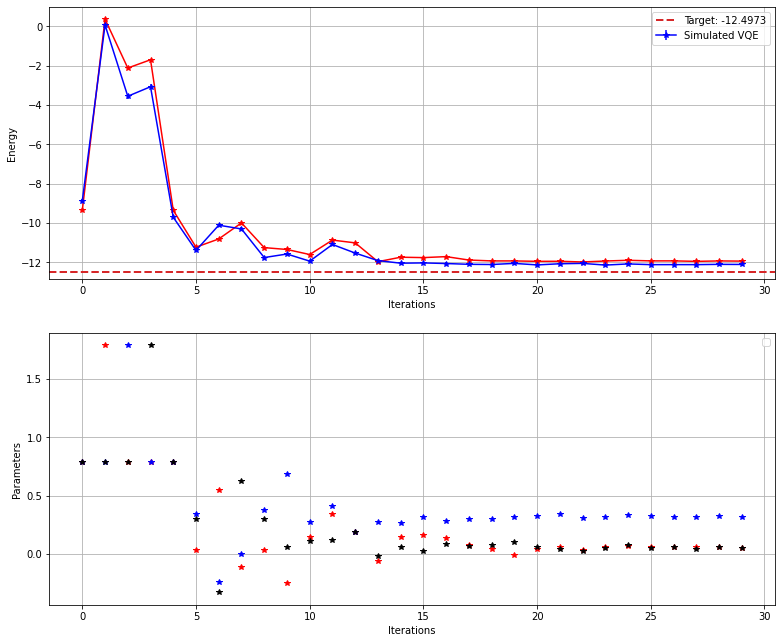

In [ ]:
# Define a simple callback function
intermediate_info = []
def callback(value):
        intermediate_info.append(value)
# Define instance of qiskit-terra's Estimator primitive
estimator = Sampler()


# Setup VQE algorithm
custom_vqe = Miti_CustomVQE(estimator,ansatz,cobyla,level_miti=0,time=time(),callback=callback)

# Run the custom VQE function and monitor execution time
start = time()
result = custom_vqe.compute_minimum_eigenvalue(H)
end = time()

print(result)
print(f'execution time (s): {end - start:.2f}')
energies_miti=[]
errors=[]
energies_ideal=[]
parameters=[]
for data in intermediate_info:
  energies_miti.append(data[0])
  errors.append(data[1])
  energies_ideal.append(data[2])
  parameters.append(data[3])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.errorbar(np.arange(len(energies_miti)),energies_miti,errors, color='blue',linestyle='-',marker='*' , label='Simulated VQE')
plt.plot(energies_ideal,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

In [ ]:
en=energies_miti[-8:]
e=statistics.mean(en)
de=statistics.stdev(en)
print(e)
print(de)

In [ ]:
QiskitRuntimeService.save_account(channel="ibm_quantum", token="c0df7c866f628346a4ad9eb0955b0b9e8ffedc7dc25fa33a87a59e50864c059fa00f211c7f611efee085a4b810646179209cc819b26a4903c733466bb8b96f51",overwrite=True)
service = QiskitRuntimeService(channel='ibm_quantum')
backend = 'ibmq_guadalupe'

options = Options()
options.resilience_level = 0
options.optimization_level = 3
options.initial_layout=initial_layout
options.shots=10000

In [ ]:
# Define a simple callback function
intermediate_info_real_backend_0= []
def callback(value):
        intermediate_info_real_backend_0.append(value)



# Define a simple callback function

start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeSampler(session=session,options=options)

    # Setup VQE algorithm
    custom_vqe = Miti_CustomVQE(rt_estimator,ansatz,cobyla,level_miti=0,time=time(),callback=callback)

    # Run the custom VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(H)
    end = time()
print(result)
print(f'execution time (s): {end - start:.2f}')



In [ ]:
energies_miti=[]
errors=[]
energies_ideal=[]
parameters=[]
for data in intermediate_info_real_backend_0:
  energies_miti.append(data[0])
  errors.append(data[1])
  energies_ideal.append(data[2])
  parameters.append(data[3])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.errorbar(np.arange(len(energies_miti)),energies_miti,errors, color='blue',linestyle='-',marker='*' , label='Simulated VQE')
plt.plot(energies_ideal,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

In [ ]:
en=energies_miti[-8:]
e=statistics.mean(en)
de=statistics.stdev(en)
print(e)
print(de)

In [ ]:
# Define a simple callback function
intermediate_info_real_backend_1= []
def callback(value):
        intermediate_info_real_backend_1.append(value)

start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeSampler(session=session,options=options)

    # Setup VQE algorithm
    custom_vqe = Miti_CustomVQE(rt_estimator,ansatz,cobyla,level_miti=1,time=time(),callback=callback)

    # Run the custom VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(H)
    end = time()
print(result)
print(f'execution time (s): {end - start:.2f}')


In [ ]:
energies_miti=[]
errors=[]
energies_ideal=[]
parameters=[]
for data in intermediate_info_real_backend_1:
  energies_miti.append(data[0])
  errors.append(data[1])
  energies_ideal.append(data[2])
  parameters.append(data[3])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.errorbar(np.arange(len(energies_miti)),energies_miti,errors, color='blue',linestyle='-',marker='*' , label='Simulated VQE')
plt.plot(energies_ideal,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

In [ ]:
en=energies_miti[-8:]
e=statistics.mean(en)
de=statistics.stdev(en)
print(e)
print(de)

In [ ]:
# Define a simple callback function
intermediate_info_real_backend_2= []
def callback(value):
        intermediate_info_real_backend_2.append(value)

options.shots=10000
start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeSampler(session=session,options=options)

    # Setup VQE algorithm
    custom_vqe = Miti_CustomVQE(rt_estimator,ansatz,cobyla,level_miti=2,time=time(),callback=callback)

    # Run the custom VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(H)
    end = time()
print(result)
print(f'execution time (s): {end - start:.2f}')


In [ ]:
energies_miti=[]
errors=[]
energies_ideal=[]
parameters=[]
for data in intermediate_info_real_backend_2:
  energies_miti.append(data[0])
  errors.append(data[1])
  energies_ideal.append(data[2])
  parameters.append(data[3])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.errorbar(np.arange(len(energies_miti)),energies_miti,errors, color='blue',linestyle='-',marker='*' , label='Simulated VQE')
plt.plot(energies_ideal,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy)
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

In [ ]:
en=energies_miti[-8:]
e=statistics.mean(en)
de=statistics.stdev(en)
print(e)
print(de)

In [ ]:
# Define a simple callback function
intermediate_info_real_backend_3= []
def callback(value):
        intermediate_info_real_backend_3.append(value)



start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeSampler(session=session,options=options)

    # Setup VQE algorithm
    custom_vqe = Miti_CustomVQE(rt_estimator,ansatz,cobyla,level_miti=3,time=time(),callback=callback)

    # Run the custom VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(H)
    end = time()
print(result)
print(f'execution time (s): {end - start:.2f}')


In [ ]:
energies_miti=[]
errors=[]
energies_ideal=[]
parameters=[]
for data in intermediate_info_real_backend_3:
  energies_miti.append(data[0])
  errors.append(data[1])
  energies_ideal.append(data[2])
  parameters.append(data[3])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.errorbar(np.arange(len(energies_miti)),energies_miti,errors, color='blue',linestyle='-',marker='*' , label='Simulated VQE')
plt.plot(energies_ideal,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

In [ ]:
en=energies_miti[-8:]
e=statistics.mean(en)
de=statistics.stdev(en)
print(e)
print(de)

In [ ]:
# Define a simple callback function
intermediate_info_real_backend_4= []
def callback(value):
        intermediate_info_real_backend_4.append(value)



start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeSampler(session=session,options=options)

    # Setup VQE algorithm
    custom_vqe = Miti_CustomVQE(rt_estimator,ansatz,cobyla,level_miti=4,time=time(),callback=callback)

    # Run the custom VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(H)
    end = time()
print(result)
print(f'execution time (s): {end - start:.2f}')


In [ ]:
energies_miti=[]
errors=[]
energies_ideal=[]
parameters=[]
for data in intermediate_info_real_backend_4:
  energies_miti.append(data[0])
  errors.append(data[1])
  energies_ideal.append(data[2])
  parameters.append(data[3])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.errorbar(np.arange(len(energies_miti)),energies_miti,errors, color='blue',linestyle='-',marker='*' , label='Simulated VQE')
plt.plot(energies_ideal,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

In [ ]:
en=energies_miti[-8:]
e=statistics.mean(en)
de=statistics.stdev(en)
print(e)
print(de)

In [ ]:
# Define a simple callback function
intermediate_info_real_backend_raw= []
def callback(value):
        intermediate_info_real_backend_raw.append(value)



# Define a simple callback function
options = Options()
options.resilience_level = 0
options.optimization_level = 3
options.initial_layout=initial_layout
options.shots=10000
start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeEstimator(session=session,options=options)


    # Setup VQE algorithm
    custom_vqe = CustomVQE(rt_estimator,ansatz,cobyla,callback=callback)

    # Run the custom VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(H)
    end = time()
print(result)
print(f'execution time (s): {end - start:.2f}')
energies_miti=[]
parameteres=[]
ideal_energy=[]
for data in intermediate_info_real_backend_raw:
  energies_miti.append(data[0])
  parameters.append(list(data[2]))
  ideal_energy.append(data[1])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.plot(energies_miti,color='blue',marker='*')
plt.plot(ideal_energy,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
print(parameters)
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

In [ ]:
en=energies_miti[-8:]
e=statistics.mean(en)
de=statistics.stdev(en)
print(e)
print(de)

In [ ]:
# Define a simple callback function
intermediate_info_real_backend_meas= []
def callback(value):
        intermediate_info_real_backend_meas.append(value)



# Define a simple callback function
simulator = service.get_backend('ibmq_qasm_simulator')
options = Options()
options.resilience_level = 1
options.optimization_level = 3
options.initial_layout=initial_layout
options.shots=10000
start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeEstimator(session=session,options=options)

    # Setup VQE algorithm
    custom_vqe = CustomVQE(rt_estimator,ansatz,cobyla,callback=callback)

    # Run the custom VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(H)
    end = time()
print(result)
print(f'execution time (s): {end - start:.2f}')
energies_miti=[]
parameters=[]
ideal_energy=[]
for data in intermediate_info_real_backend_meas:
  energies_miti.append(data[0])
  parameters.append(list(data[2]))
  ideal_energy.append(data[1])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.plot(energies_miti,color='blue',marker='*')
plt.plot(ideal_energy,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
print(parameters)
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

In [ ]:
en=energies_miti[-8:]
e=statistics.mean(en)
de=statistics.stdev(en)
print(e)
print(de)

In [ ]:
# Define a simple callback function
intermediate_info_real_backend_zne= []
def callback(value):
        intermediate_info_real_backend_zne.append(value)



# Define a simple callback function
simulator = service.get_backend('ibmq_qasm_simulator')
options = Options()
options.resilience_level = 2
options.optimization_level = 3
options.initial_layout=initial_layout

options.shots=10000
start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeEstimator(session=session,options=options)

    # Setup VQE algorithm
    custom_vqe = CustomVQE(rt_estimator,ansatz,cobyla,callback=callback)

    # Run the custom VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(H)
    end = time()
print(result)
print(f'execution time (s): {end - start:.2f}')
energies_miti=[]
parameters=[]
ideal_energy=[]
for data in intermediate_info_real_backend_zne:
  energies_miti.append(data[0])
  parameters.append(list(data[2]))
  ideal_energy.append(data[1])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.plot(energies_miti,color='blue',marker='*')
plt.plot(ideal_energy,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
print(parameters)
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

In [ ]:
en=energies_miti[-8:]
e=statistics.mean(en)
de=statistics.stdev(en)
print(e)
print(de)

In [ ]:
# Define a simple callback function
intermediate_info_real_backend_PEC= []
def callback(value):
        intermediate_info_real_backend_PEC.append(value)



# Define a simple callback function
options = Options()
options.resilience_level = 3
options.optimization_level = 3
options.initial_layout=initial_layout

options.shots=10000
start = time()
with Session(service=service, backend=simulator) as session:
    # Prepare primitive
    rt_estimator = RuntimeEstimator(session=session,options=options)

    # Setup VQE algorithm
    custom_vqe = CustomVQE(rt_estimator,ansatz,cobyla,callback=callback)

    # Run the custom VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(H)
    end = time()
print(result)
print(f'execution time (s): {end - start:.2f}')
energies_miti=[]
parameteres=[]
ideal_energy=[]
for data in intermediate_info_real_backend_zne:
  energies_miti.append(data[0])
  parameters.append(list(data[2]))
  ideal_energy.append(data[1])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.plot(energies_miti,color='blue',marker='*')
plt.plot(ideal_energy,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
print(parameters)
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

In [ ]:
en=energies_miti[-8:]
e=statistics.mean(en)
de=statistics.stdev(en)
print(e)
print(de)